In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
from albumentations import Compose, HorizontalFlip, RandomContrast, Crop, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded, Normalize, Resize, ColorJitter
import os
import os.path
import sys
import cv2
import timm
from tqdm import tqdm
import random
import seaborn as sns
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
%cd ../..

C:\


In [3]:
!echo %cd%

C:\


### Набор данных

**[Caltech-256](https://data.caltech.edu/records/nyy15-4j048)** - это сложный набор данных для распознавания объектов, содержащий 30 607 изображений реального мира разных размеров, охватывающих 257 классов (256 классов объектов и дополнительный класс помех). Каждый класс представлен не менее чем 80 изображениями. Набор данных является надмножеством набора данных Caltech-101. Кроме того, этот набор данных несбалансирован. Категории объектов чрезвычайно разнообразны, начиная от кузнечика и заканчивая картманом. Распределение изображений по категориям таково:

- Min: 80

- Mean: 119

- Max: 827

Данные собраны из Google Images, а затем в ручную отсеяны изображения не соответствующих исходным классам. По сравнению с предшественником устранены повторы изображений. Собран скриптами, основным критерим отбора изображений стала минимальная площадь изображения (ширина на выстору > 100). В данном наборе данных отсутствует выравнивание изображений (т.е. наример в **Caltech-101** порядок изображений класса самолет был следующий: сначала шли изображения с самолетами повернутыми вправо, а затем влево) здесь же выравнивание отсутствует, что приближает данные к реальным условиям. Первая публикая была сделана в 2006 году следующими авторами: Greg Griffin, Alex Holub и Pitro Perona независимое агенство NASA.

## Распределение данных

Данные деляться произвольно пользователем в заданном им соотношении. Ниже приведен код по разбивке данных на тренировку, валидацию и тестирование.

## Формирование DataFrame, из которого будут собираться train_lst.txt, val_lst.txt, test_lst.txt

In [4]:
SEED = 0 # 2048
TRAIN_SIZE = 0.6
VAL_SIZE = 0.2
TEST_SIZE = 0.2
root_dir = './256_ObjectCategories'
all_paths = os.listdir(root_dir)

df = pd.DataFrame()
images = []
labels = []
labels_ind = []
counter = 0
for folder_path in tqdm(all_paths, total=len(all_paths)):
    image_paths = os.listdir(f"{root_dir}/{folder_path}")
    label = folder_path.split('.')[-1]
    label_ind = int(folder_path.split('.')[0]) - 1
    
    if label == 'clutter':
        continue

    # save image paths in the DataFrame
    for image_path in image_paths:
        if image_path.split('.')[-1] == 'jpg':
            images.append(f"{root_dir}/{folder_path}/{image_path}"[2:])
            labels_ind.append(label_ind)
            labels.append(label)
            counter += 1
        else:
            print(f"{root_dir}/{folder_path}/{image_path}")
df = pd.DataFrame({
    'image_path': images,
    'labels': labels_ind,
    'description': labels,
})

100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 2869.29it/s]

./256_ObjectCategories/198.spider/RENAME2


## Формирование и сохранение all_data.txt

In [5]:
img_lbl_name = []
counter = 0
for folder_path in tqdm(all_paths, total=len(all_paths)):
    image_paths = os.listdir(f"{root_dir}/{folder_path}")
    label = folder_path.split('.')[-1]
    label_ind = int(folder_path.split('.')[0]) - 1
    
    if label == 'clutter':
        continue

    for image_path in image_paths:
        if image_path.split('.')[-1] == 'jpg':
            meta = f"{root_dir}/{folder_path}/{image_path} {label_ind} {label}"[2:]
            img_lbl_name.append(meta)
            counter += 1
        else:
            print(f"{root_dir}/{folder_path}/{image_path}")

100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 4513.78it/s]

./256_ObjectCategories/198.spider/RENAME2


## Формирование и сохранение train_lst.txt, val_lst.txt, test_lst.txt

In [6]:
lbl = df.labels.unique()
lst_train = []
lst_val = []
lst_test = []
for i in lbl:
    df_lbl = df.loc[df['labels'] == i]
    num_cl_img = df_lbl.shape[0]
    tr = int(num_cl_img * TRAIN_SIZE)
    v = int(num_cl_img * VAL_SIZE)
    te = num_cl_img - tr - v
    
    df_val = df_lbl.sample(n=v, random_state=SEED).index
    df_lbl = df_lbl.drop(df_val)
    lst_val += list(df_val)
    
    df_test = df_lbl.sample(n=te, random_state=SEED).index
    df_lbl = df_lbl.drop(df_test)
    lst_test += list(df_test)
    
    lst_train += list(df_lbl.index)

## Визуальная оценка равномерного распределения классов на каждом сете

In [9]:
df_train = df.iloc[lst_train]
df_val = df.iloc[lst_val]
df_test = df.iloc[lst_test]

import plotly.graph_objects as go

def plting_dist(name, df):
    print(f'Number of images: {df.shape[0]}')
    df_stat = df.labels.value_counts()
    result = [df_stat.loc[i] for i in range(df_stat.shape[0])]
    fig = go.Figure(
        data=[go.Bar(y=result)],
        layout_title_text=name
    )
    fig.show()

### Итоговое распределение классов для тренировки

Number of images: 17772


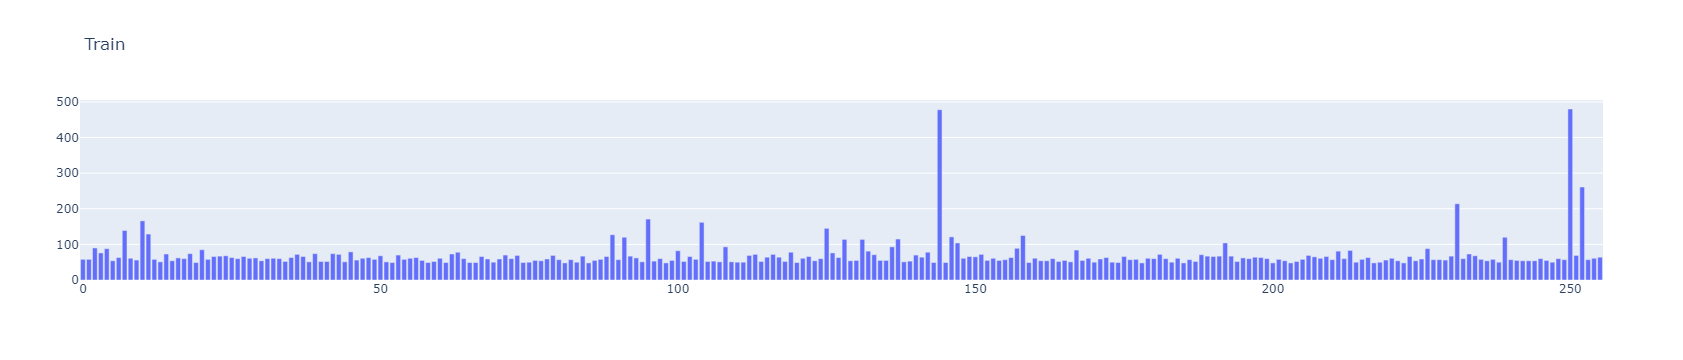

In [10]:
plting_dist(name='Train', df=df_train)

### Итоговое распределение классов для валидации

Number of images: 5862


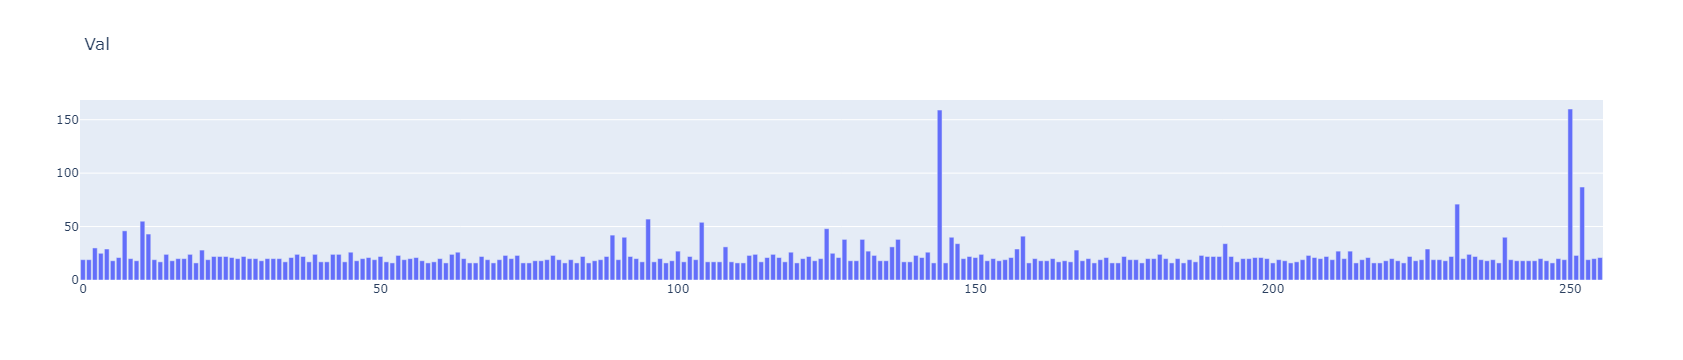

In [11]:
plting_dist(name='Val', df=df_val)

### Итоговое распределение классов для тестирования

Number of images: 6146


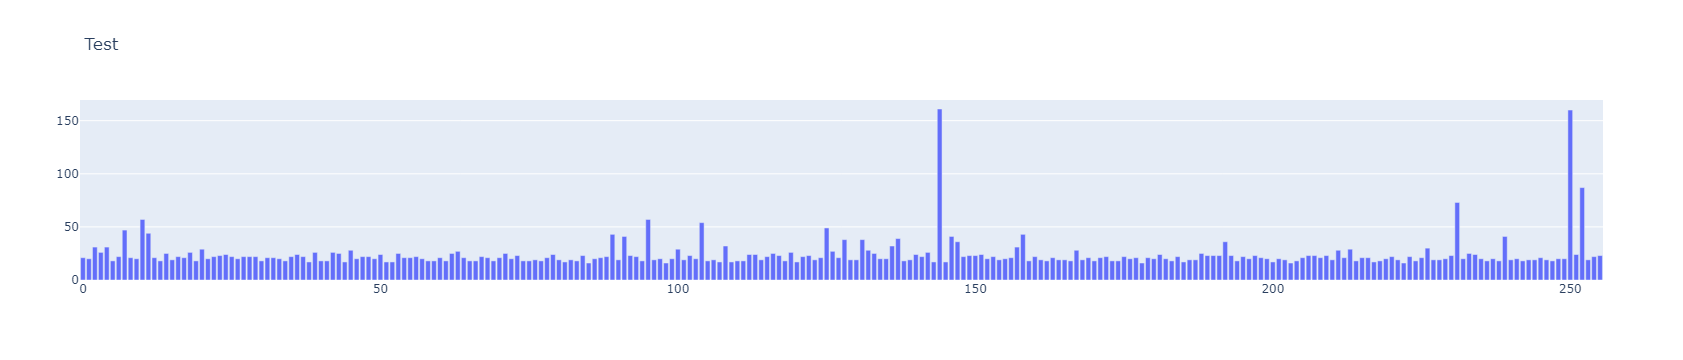

In [12]:
plting_dist(name='Test', df=df_test)

### Где используется в каких работах

Применяется для тестирования сгенерированных моделей автоэмелем

Данный датасет был сформирован из изображений находящихся в открытом доспутупе в интернете, при использовании transfer learning на модели предобученной на ImageNet, при правильно подобронном learning rate с первой эпохи может быть полуена метрика accuracy больще 80%. Так происходит из за большого пересечения классов. Но при этом максимальная точность трудно достижима, поскольку данные являются несбалансированными. Также применятся для тестирования сгенированных сетей.

На этих данных могут использоваться следующие классические нейросетевые модели:

- ResNet18-152

- MobilenetV2-V3

- VGG

- ResNeXt

- Se-ResNet - Xt

- Inception

- и монгие другие

Данный набор данных применяется в следующих статьях:

> [Pervasive Label Errors in Test Sets Destabilize Machine Learning Benchmarks](https://paperswithcode.com/paper/pervasive-label-errors-in-test-sets)

> [A Review of Single-Source Deep Unsupervised Visual Domain Adaptation](https://paperswithcode.com/paper/a-review-of-single-source-deep-unsupervised)

> [Tencent ML-Images: A Large-Scale Multi-Label Image Database for Visual Representation Learning](https://paperswithcode.com/paper/tencent-ml-images-a-large-scale-multi-label)

> [Explicit Inductive Bias for Transfer Learning with Convolutional Networks](https://paperswithcode.com/paper/explicit-inductive-bias-for-transfer-learning)

> [Importance Weighted Adversarial Nets for Partial Domain Adaptation](https://paperswithcode.com/paper/importance-weighted-adversarial-nets-for)

А также во многих других.

# Применение готовой модели и визуализация данных

### Определение устройства на котором будут производиться вычисления.

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else th.device('cpu')

### Создание кастомного датасета для дальнейшего обучения модели

In [14]:
class MyDataset(torch.utils.data.Dataset):
    """
    self.transform -- накладываемые аугментации на изображение
    self.work_dir -- рабочая дирректория
    self.data_dir -- дирректория с данными
    self.df -- сформированные данные (из исходной разметки)
    """
    def __init__(self, file='', transforms=None, data_dir=''):
        self.transform = transforms
        self.file = file
        self.work_dir = './'
        self.data_dir = data_dir
        data = self.data_parsing()
        self.df=pd.DataFrame(data, columns=list(range(0, 2)))

    """
    Функция получения размера данных
    """
    def __len__(self):
        return len(self.df)

    """
    Функция получения одного элемента данных из сформированного датафрейма
    """
    def __getitem__(self, idx):
        label = self.df.iloc[idx, 1]
        path = self.df.iloc[idx, 0]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            transforming = self.transform(image=image)
            image = transforming["image"]
        image = torchvision.transforms.functional.to_tensor(image)
        return image, label

    """
    Поскольку разметка данных представленна в видет текстового файла -> необходиом его пропарсить
    """
    def data_parsing(self):
        file_name = f"{self.file}_lst.txt"
        print(file_name)
        data = open(file_name, 'r')
        lst = list()
        while True:
            tmp = data.readline()
            if not tmp:
                break
            tmp = tmp.split()
            # добавляем в список путь до картинки и ее лэйбл
            lst.append([f"{self.work_dir}{tmp[0]}", int(tmp[1])])
        return lst

### Создание даталоадера для тренировки модели

Ниже приведена функция создания даталоадера

In [17]:
def CreatingDataloaderTrainVal(batch=64):
    data_transforms_train = {'train': Compose([
                Resize(260, 260, p=1.0),
                OneOf([
                    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
                    RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=0.5)
                ], p=1),
                RandomCrop(width=224, height=224),
                HorizontalFlip(p=0.5),               
                Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
    ]),
    'val': Compose([Resize(224, 224, p=1.0),
                        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), 
                        ])}

    data_dir = './256_ObjectCategories/'
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    image_dataset_train = {'train': MyDataset('train', data_transforms_train['train'], data_dir), 'val': MyDataset('val', data_transforms_train['val'], data_dir)}
    dataloader_train = {x: torch.utils.data.DataLoader(image_dataset_train[x], batch_size=batch, shuffle=True, num_workers=0) for x in ['train', 'val']}
    dataset_sizes_train = {x: len(image_dataset_train[x]) for x in ['train', 'val']}
    dataloader_val = torch.utils.data.DataLoader(image_dataset_train['val'], batch_size=batch, shuffle=False, num_workers=2)
    return dataloader_train, dataset_sizes_train, image_dataset_train

### Пример рассматриваемых данных 

Ниже приведены изображения с соответствующими им классами.

train_lst.txt
val_lst.txt


C:\Users\wqsad\AppData\Local\Temp\ipykernel_11992\3977205578.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



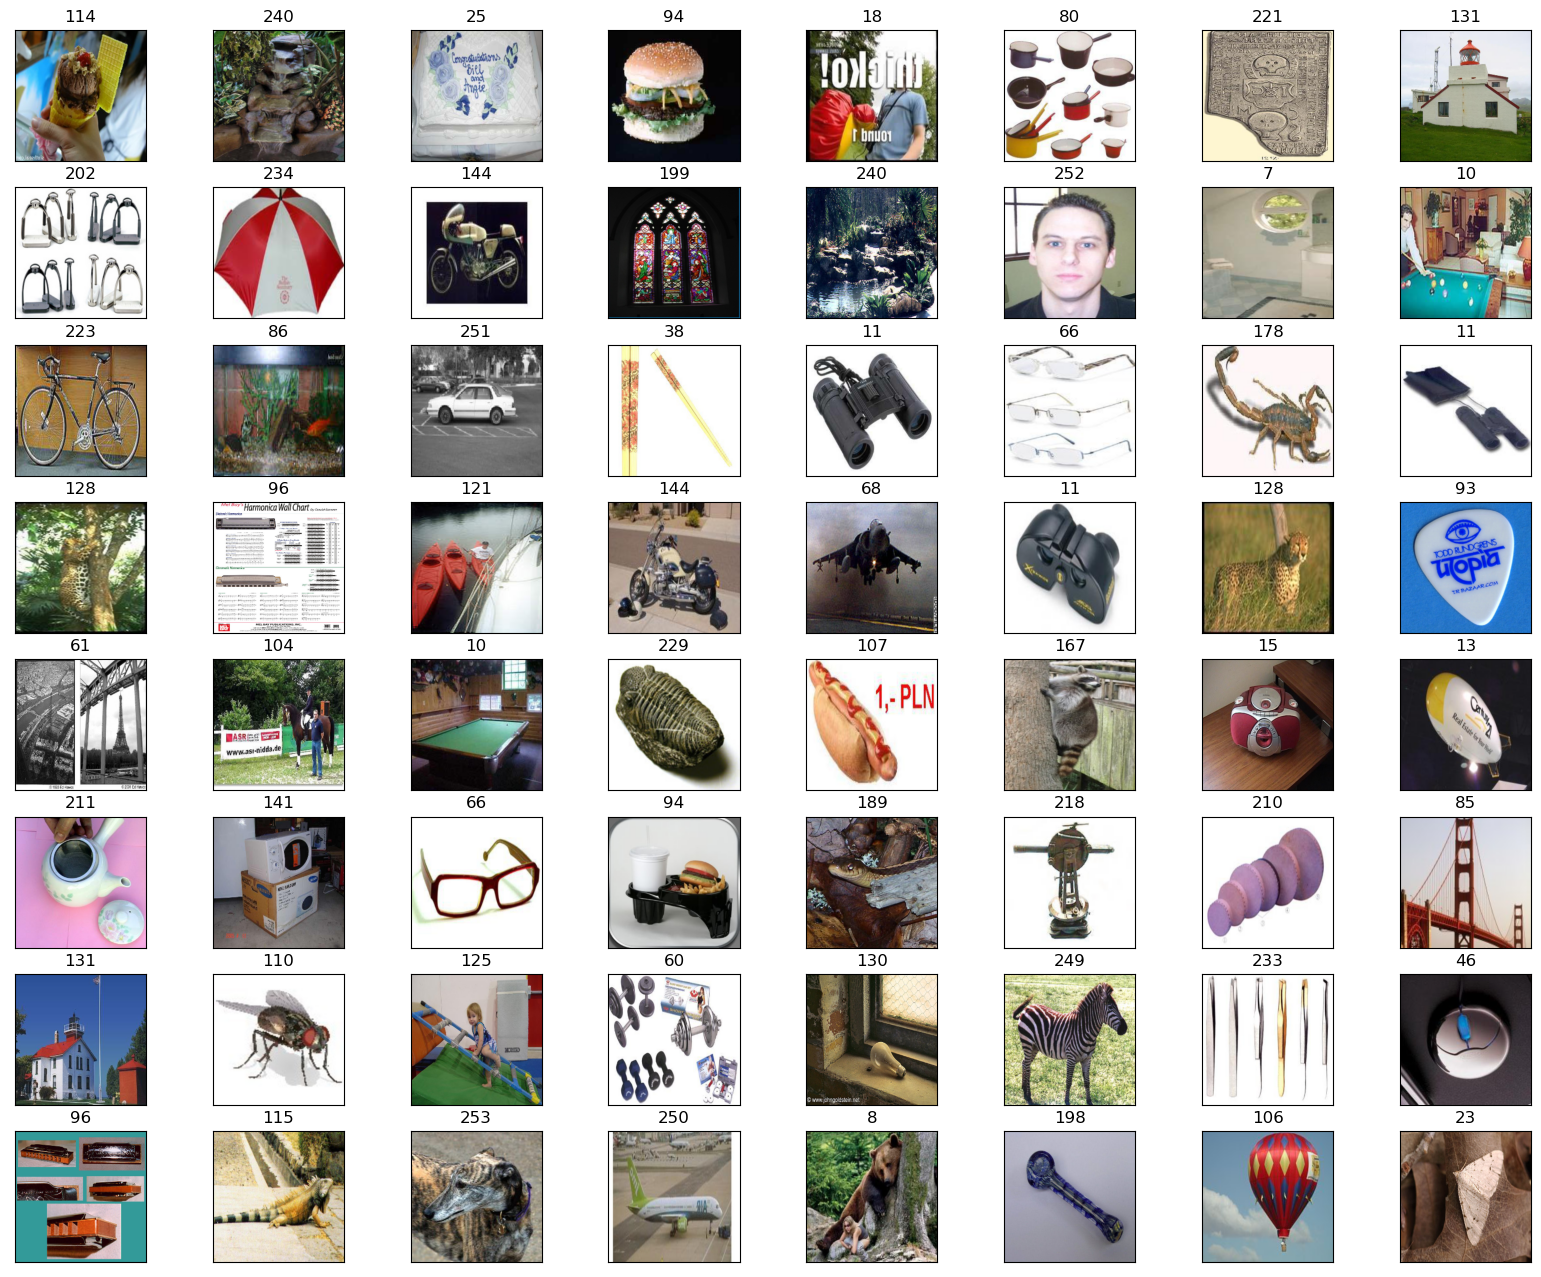

In [16]:
import numpy as np
from matplotlib import pyplot as plt

dataloader_train, dataset_sizes_train, image_dataset_train = CreatingDataloaderTrainVal(batch=64)
img, lbl = next(iter(dataloader_train['train']))

"""
Функция визуалищации изображений
"""
def plt_result(img, lbl):
    fig,axes = plt.subplots(int(len(lbl)/ 8), 8, figsize = (20, 16))
    for idc, simg in enumerate(img.detach().cpu()):
        axes[idc // 8, idc % 8].imshow(simg.permute(1,2,0))
        axes[idc // 8, idc % 8].set_title(f'{lbl[idc]}')
    [ax.get_xaxis().set_visible(False) for ax in  fig.axes]
    [ax.get_yaxis().set_visible(False) for ax in fig.axes]
    plt.savefig('foo.png')
    fig.show()
    
plt_result(img, lbl)

### Загрузка предтренированной модели, создание функции ошбики и оптимизатора

In [18]:
class Models():
    def __init__(self, device='0'):
        device = 'cuda'
        self.device = torch.device(device) if torch.cuda.is_available() else torch.device('cpu')

    def CreatingTimmModel(self, epoch, classes, lr, data, models, opt, scheduler=None, step_size=None, batch_s=64, crop=False):
        model = timm.create_model(models, pretrained=True, num_classes=classes)
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        learning_rate = torch.tensor(lr)
        optimizer_ft = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        return model, criterion, optimizer_ft

### Функция тренировки модели

In [19]:
def train(model, criterion, optimizer, scheduler, num_epochs=25, data='xray', batch_s=64, crop=False):
    dataloader, dataset_sizes, image_dataset_train = CreatingDataloaderTrainVal(batch_s)
    train_loss, train_score, optim_lr, val_loss, val_score = [], [], [], [], []
    best_score = 0.0
    for epoch in range(num_epochs):
        model.train()
        runing_loss = 0.0
        score = 0
        for img, lbl in tqdm(dataloader['train']): # image_dataset_train
            img = img.to(device, non_blocking=True)
            lbl = lbl.to(device, non_blocking=True)
            optimizer.zero_grad()
            out = model(img) # .unsqueeze(0)
            # print(out.shape, lbl.shape)
            _, preds = torch.max(out, 1)
            loss = criterion(out, lbl) # .to(torch.float32) .to(torch.long)
            loss.backward()
            optimizer.step()
            runing_loss += loss.item() * img.size(0)
            score += torch.sum(preds == lbl.data)
        epoch_acc = score.double() / dataset_sizes['train']
        runing_loss = runing_loss / dataset_sizes['train']
        print("Epoch of train:", epoch + 1, "score: [", epoch_acc.item(), "], loss: [", runing_loss, "]")
        
        train_loss.append(runing_loss)
        train_score.append(epoch_acc)
        optim_lr.append(optimizer.param_groups[0]['lr'].item())
        score = 0
        runing_loss = 0.0
        model.eval()
        with torch.no_grad():
            for img, lbl in tqdm(dataloader['val']):
                img = img.to(device, non_blocking=True)
                lbl = lbl.to(device, non_blocking=True)
                out = model(img)
                # print(out.shape)
                _, preds = torch.max(out, 1)
                loss = criterion(out.to(torch.float32), lbl.to(torch.long))
                runing_loss += (loss.item() / 2) * img.size(0)
                score += torch.sum(preds == lbl.data)
        epoch_acc = score.double() / dataset_sizes['val']
        runing_loss = runing_loss / dataset_sizes['val']
        print("Epoch of val:", epoch + 1, "score: [", epoch_acc.item(), "], loss: [", runing_loss, "]")

        val_loss.append(runing_loss)
        val_score.append(epoch_acc)
        if epoch == 0:
            best_loss = runing_loss
        if epoch_acc > best_score and runing_loss <= best_loss:
            best_score = epoch_acc
            best_loss = runing_loss
    return best_score, best_loss, train_loss, train_score, optim_lr, val_loss, val_score

### Фиксирование рандома для автовоиспроизводимости результатов

In [20]:
def set_seed(seed=1):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Обучение модели ResNet18

In [21]:
set_seed() # фиксирование рандома

"""
Объявление параметров передаваемых в функцию обучения
"""
model = Models(device='0')
datas = ['caltech']
classes = [256]
models = ['resnet18'] 
crop_s = [True]
step_sizes = [100]
epoch = [8]
schedulers = [None]
lr = [0.001]
opt = ['AdamW']
batch_size = [16]
train_loss, train_score, optim_lr, val_loss, val_score = [], [], [], [], []

for data, classes_iter in zip(datas, classes):
    for epochs, step_size, crop, iter_model, batch in zip(epoch, step_sizes, crop_s, models, batch_size):
        for optim in opt:
            for lr_iter in lr:
                model_ft, criterion, optimizer_ft = model.CreatingTimmModel(epochs, classes_iter, lr_iter, data, iter_model, optim, schedulers[0], step_size, batch, crop)
                best_score, best_loss, train_loss, train_score, optim_lr, val_loss, val_score = train(model_ft, criterion, optimizer_ft, None, num_epochs=epochs, data=data, batch_s=batch, crop=crop) # exp_lr_scheduler

train_lst.txt
val_lst.txt


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [12:06<00:00,  1.55it/s]


Epoch of train: 1 score: [ 0.04336508639787328 ], loss: [ 5.440234531171035 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:15<00:00,  4.87it/s]


Epoch of val: 1 score: [ 0.07898328215626067 ], loss: [ 2.4985830577230828 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [09:48<00:00,  1.92it/s]


Epoch of train: 2 score: [ 0.07919805050952591 ], loss: [ 4.902533429990472 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:08<00:00,  5.37it/s]


Epoch of val: 2 score: [ 0.11566018423746162 ], loss: [ 2.225922005772794 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [09:31<00:00,  1.97it/s]


Epoch of train: 3 score: [ 0.12948604342046965 ], loss: [ 4.385881967971322 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:14<00:00,  4.91it/s]


Epoch of val: 3 score: [ 0.19839645172296147 ], loss: [ 1.927742143370356 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [10:09<00:00,  1.85it/s]


Epoch of train: 4 score: [ 0.18514621178555604 ], loss: [ 3.982328242942935 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:22<00:00,  4.45it/s]


Epoch of val: 4 score: [ 0.2741385192766974 ], loss: [ 1.6729096757474917 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [10:05<00:00,  1.86it/s]


Epoch of train: 5 score: [ 0.23521267168808152 ], loss: [ 3.637478015990082 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:22<00:00,  4.47it/s]


Epoch of val: 5 score: [ 0.32258614807233027 ], loss: [ 1.549537447482317 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [10:06<00:00,  1.86it/s]


Epoch of train: 6 score: [ 0.277414709791759 ], loss: [ 3.3939889972063098 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:20<00:00,  4.53it/s]


Epoch of val: 6 score: [ 0.3710337768679632 ], loss: [ 1.4369356055505362 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [10:10<00:00,  1.85it/s]


Epoch of train: 7 score: [ 0.31889676561807706 ], loss: [ 3.172517065458927 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:21<00:00,  4.49it/s]


Epoch of val: 7 score: [ 0.38178096212896623 ], loss: [ 1.4092027251527643 ]


100%|██████████████████████████████████████████████████████████████████████████████| 1129/1129 [10:01<00:00,  1.88it/s]


Epoch of train: 8 score: [ 0.34603455914931325 ], loss: [ 3.016037874745752 ]


100%|████████████████████████████████████████████████████████████████████████████████| 367/367 [01:39<00:00,  3.68it/s]

Epoch of val: 8 score: [ 0.4095871716137837 ], loss: [ 1.3238501881869813 ]


### Использование Tensorboard

#### Логирование изображений 

In [22]:
dataloader, dataset_sizes, image_dataset_train = CreatingDataloaderTrainVal(32)
writer = SummaryWriter('runs/')
images, labels = next(iter(dataloader['train']))
img_grid = torchvision.utils.make_grid(images)
writer.add_image('four_fashion_mnist_images', img_grid)

train_lst.txt
val_lst.txt


#### Логирование графа применяемой модели

In [23]:
images, labels = next(iter(image_dataset_train['val']))
model = timm.create_model('resnet18', pretrained=True, num_classes=256)
writer.add_graph(model, images.unsqueeze(0))
writer.close()

#### Логирование процесса обучения

In [25]:
writer = SummaryWriter()

for n_iter in range(len(train_loss)):
    writer.add_scalar('Loss/train', train_loss[n_iter], n_iter)
    writer.add_scalar('Loss/val', val_loss[n_iter], n_iter)
    writer.add_scalar('Accuracy/train', train_score[n_iter], n_iter)
    writer.add_scalar('Accuracy/val', val_score[n_iter], n_iter)

In [26]:
%load_ext tensorboard

In [30]:
tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 11892), started 0:00:15 ago. (Use '!kill 11892' to kill it.)

### Логирование процесса обучения

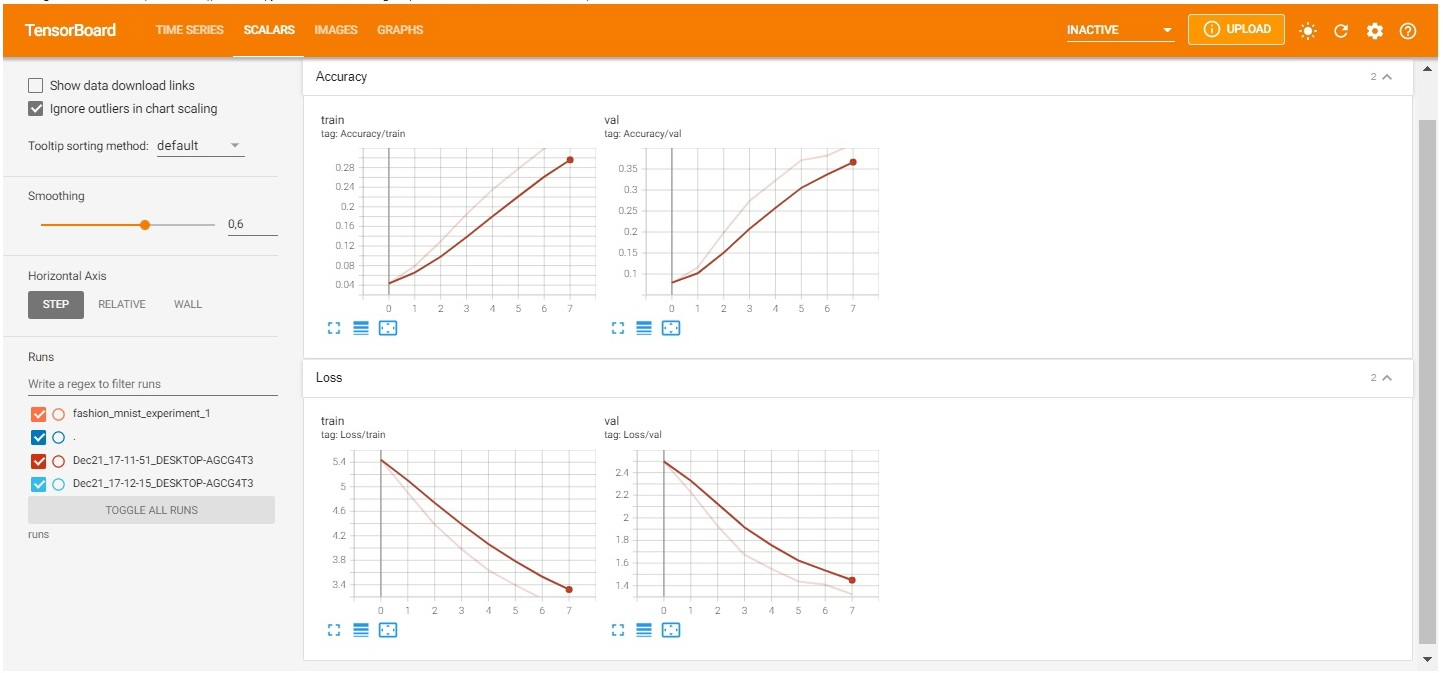

### Логирование примеров изображений

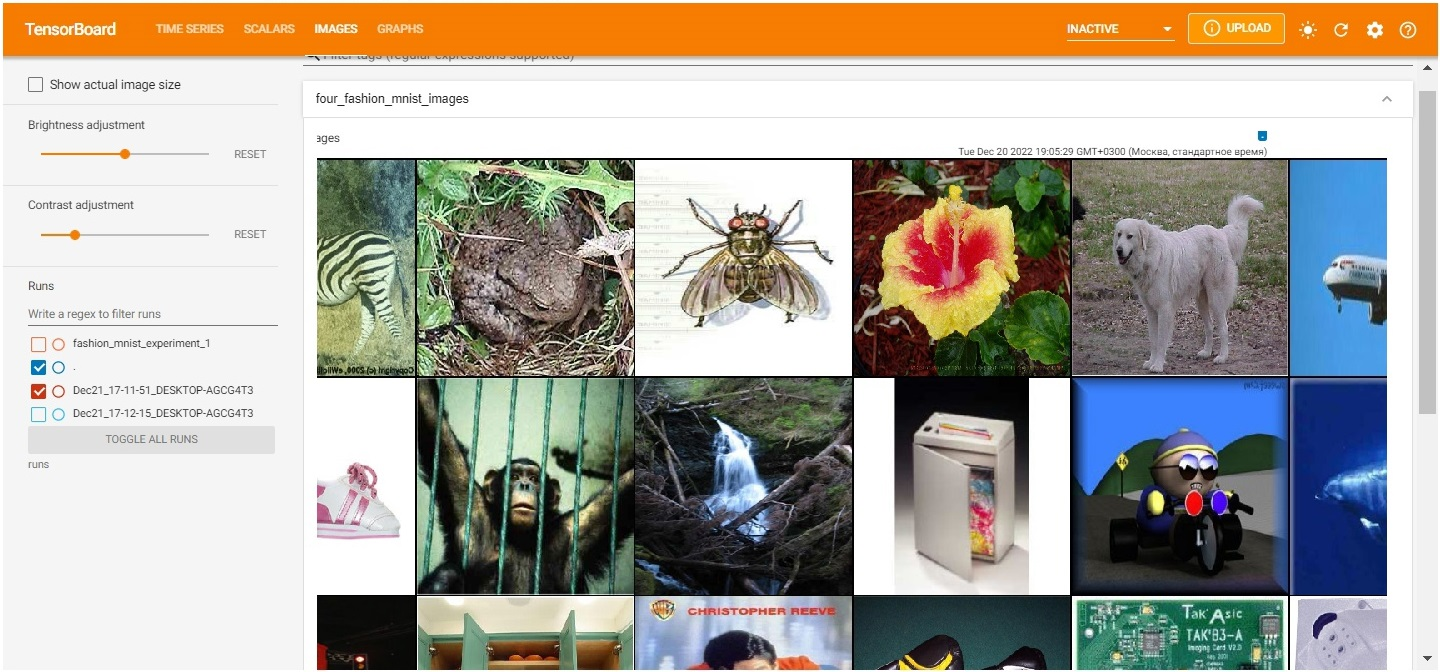

### Логирование графа модели

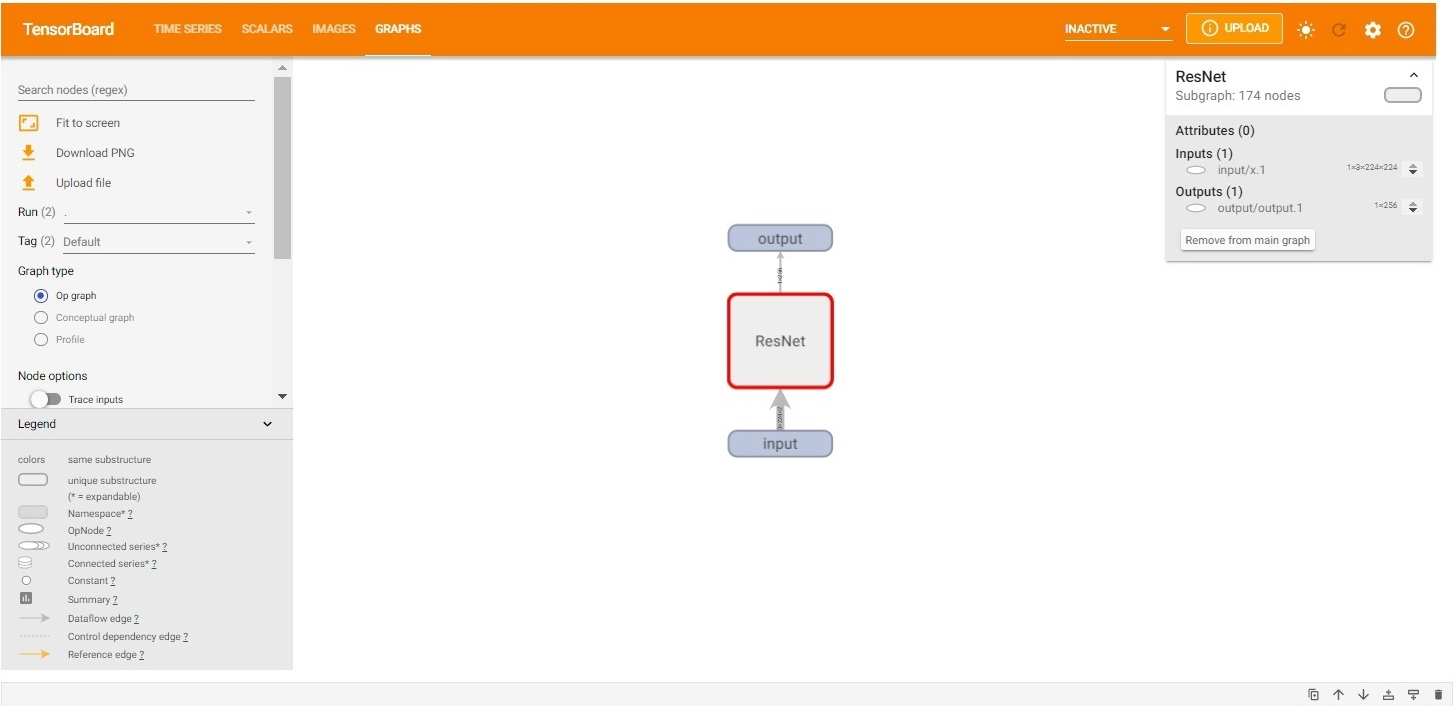

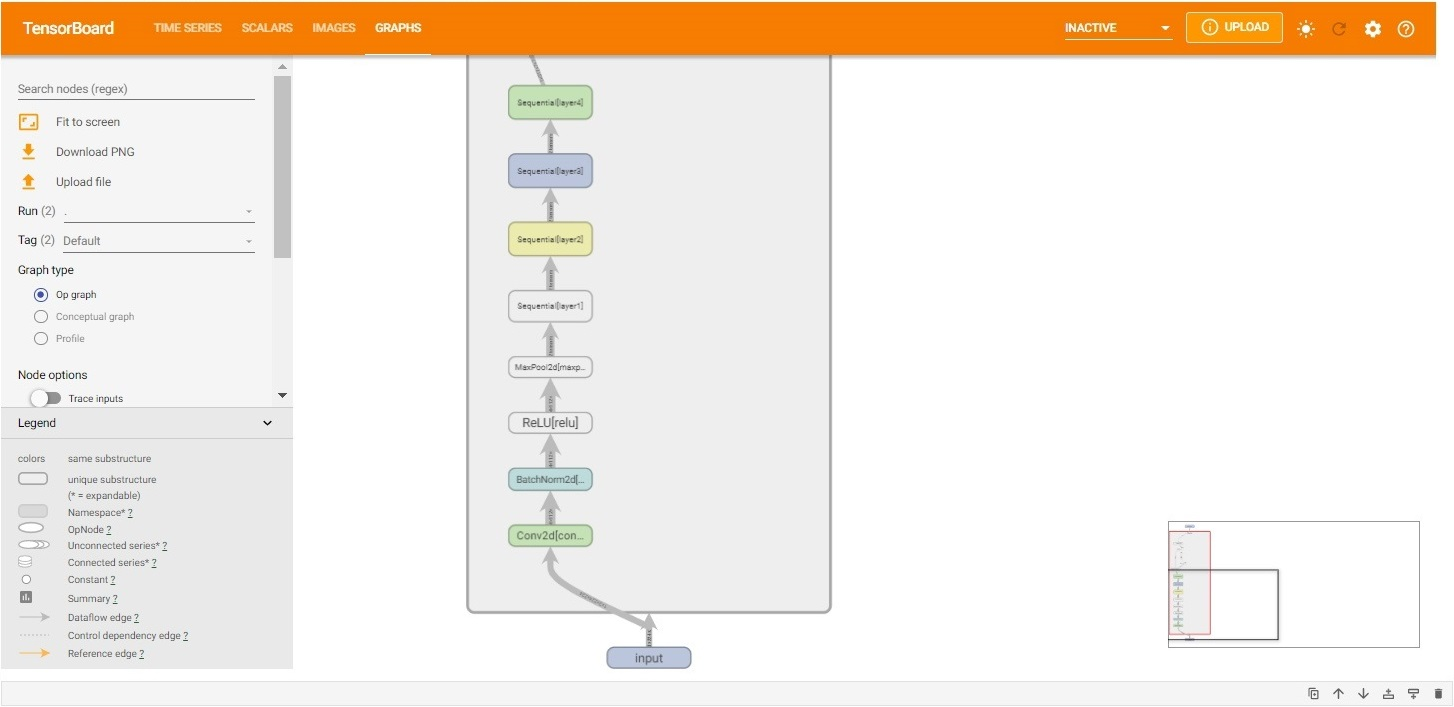